<font color="#e32b3d"><h1>Faster RCNN</h2></font>

<font color="#822b34"><h2>*PASCAL Dataset*</h2></font>
<font color="#2ff9b3d"><h1>Part 1: Importing Datasets and Pre-processing </h1></font>

required library and packages are imported.

In [9]:
# Import library
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset

import torchvision
from torchvision import transforms

import matplotlib.pyplot as plt
import numpy as np
import glob
import os

Importing the pre-trained model of Faster RCNN.

output features of the last layer must change according to the number of objects for this specific dataset which including the backgroud is equal to 6. therefore the last layer of the model is replaces with *FastRCNNPredictor*.

In [10]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
def get_model(num_classes):
  # Loading the pre-trained model
  model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
  in_features = model.roi_heads.box_predictor.cls_score.in_features
  # Changing the last layer
  model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
  return model


In [11]:
model = get_model(6)

In [12]:
model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

Transferring the model to cuda.

In [13]:
model = model.to("cuda")

Mounting the *Google Drive* in order to access the PASCAL dataset.

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
TRAIN_DIR = "/content/drive/MyDrive/PASCAL/train"
TEST_DIR = "/content/drive/MyDrive/PASCAL/test"
VAL_DIR = "/content/drive/MyDrive/PASCAL/val"

Loading the dataset of train, validation and test.

In [16]:
from pascal_dataset import PASCALDataset
# PASCALDataset function is changed so that it Resizes all images to be the same size
Train_dataset = PASCALDataset(TRAIN_DIR)
Test_dataset = PASCALDataset(TEST_DIR)
Val_dataset = PASCALDataset(VAL_DIR)
PASCAL_Classes = [_,'person', 'bicycle', 'car', 'motorbike', 'airplane']#Blank is for background
color_list = ['red', 'green', 'blue', 'yellow', 'blue', 'orange']

getting to know the dataset:

In [17]:
## Image tensor
Train_dataset[0][0]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


tensor([[[0.3647, 0.3676, 0.3663,  ..., 0.3608, 0.3598, 0.3569],
         [0.3647, 0.3676, 0.3663,  ..., 0.3591, 0.3581, 0.3551],
         [0.3645, 0.3674, 0.3662,  ..., 0.3566, 0.3557, 0.3529],
         ...,
         [0.4647, 0.4476, 0.4574,  ..., 0.6665, 0.6488, 0.5983],
         [0.5069, 0.4896, 0.5011,  ..., 0.6077, 0.5699, 0.5260],
         [0.5412, 0.5265, 0.5399,  ..., 0.5588, 0.5069, 0.4745]],

        [[0.5333, 0.5363, 0.5350,  ..., 0.5294, 0.5284, 0.5255],
         [0.5333, 0.5363, 0.5350,  ..., 0.5277, 0.5267, 0.5238],
         [0.5331, 0.5360, 0.5349,  ..., 0.5252, 0.5243, 0.5216],
         ...,
         [0.4608, 0.4437, 0.4534,  ..., 0.4462, 0.4472, 0.4931],
         [0.5029, 0.4857, 0.4972,  ..., 0.5199, 0.4863, 0.5196],
         [0.5373, 0.5225, 0.5359,  ..., 0.5627, 0.5039, 0.5333]],

        [[0.7020, 0.7049, 0.7036,  ..., 0.6980, 0.6971, 0.6941],
         [0.7020, 0.7049, 0.7036,  ..., 0.6963, 0.6953, 0.6924],
         [0.7017, 0.7047, 0.7035,  ..., 0.6939, 0.6930, 0.

In [18]:
## Target Digtionary
Train_dataset[0][1]

{'boxes': tensor([[ 16.8000, 236.8000, 570.0000, 460.8000]]),
 'labels': tensor([5]),
 'image_id': tensor([0]),
 'area': tensor([64540.]),
 'iscrowd': tensor([0])}

Checking the dataset dimensions.

In [19]:
print("PASCAL Train set has "+str(len(Train_dataset.imgs)) + " images.")
print("PASCAL Test set has "+str(len(Test_dataset.imgs)) + " images.")
print("PASCAL Validation set has "+str(len(Val_dataset.imgs)) + " images.")

PASCAL Train set has 1002 images.
PASCAL Test set has 200 images.
PASCAL Validation set has 200 images.


Defining a function to plot an image from the dataset and alongside its bounding boxes.

In [20]:
from matplotlib import patches
def plot_dataset_image (img_trgt):
  fig = plt.figure()
  axe = fig.add_axes([0, 0, 1, 1])
  img = img_trgt[0] # image tensors
  trgt = img_trgt[1] #bounding boxes, labels, area, ...
  labels = trgt["labels"].cpu().detach().numpy()
  boxes = trgt["boxes"]
  #required lists
  unique_patch_list=[]
  unique_labels = []
  unique_indexes = []
  counts = []
  for t in range(labels.shape[0]):
    if (labels[t] in unique_labels ):
      # label is already stored, just increment the count
      counts[unique_labels.index(labels[t])]+=1
      continue
    else:
      # new label
      counts.append(1)
      unique_labels.append(labels[t])
      unique_indexes.append(t)

  for i in range(labels.shape[0]):
    w = boxes[i][2] - boxes[i][0]#width
    h = boxes[i][3] - boxes[i][1]#height
    #plotting the bounding box
    box = patches.Rectangle((boxes[i][0], boxes[i][1]), w, h, edgecolor=color_list[labels[i]], facecolor="none")
    patchh = axe.add_patch(box)
    if(i in unique_indexes):
      #store the patches for legend function
      unique_patch_list.append(patchh)
  l = []
  for j in range(len(unique_labels)):
    #create labels
    l.append(str(PASCAL_Classes[unique_labels[j]])+" : "+str(counts[j]))
  plt.legend(handles=unique_patch_list, labels = l)
  plt.title("EXPECTED OUTPUT")
  #plot the image
  plt.imshow(img.permute(1, 2, 0))

Randomly plotting an image from Train dataset.

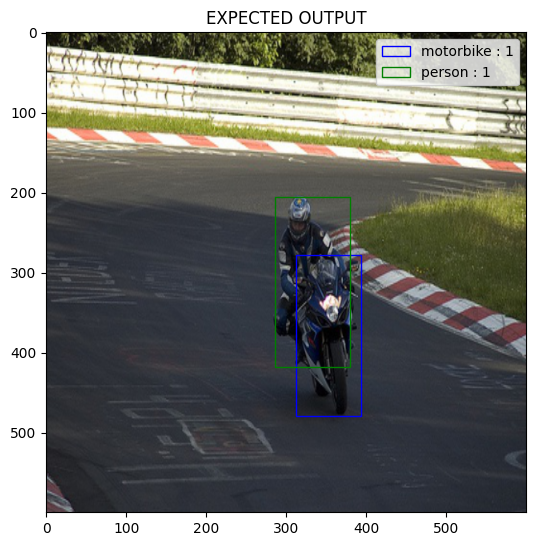

In [40]:
from numpy.random import randint
for i in (randint(0, len(Train_dataset.imgs)-1, 1)):
  plot_dataset_image(Train_dataset[i])

Creating Train and Test dataloaders for train and test phases.

In [22]:
## Creating DataLoaders
PASCAL_train_dataloader = DataLoader(
    dataset = Train_dataset,
    batch_size = 1,
    shuffle = True
)

PASCAL_Test_dataloader = DataLoader(
    dataset = Test_dataset,
    batch_size = 1,
    shuffle = True
)

Training the model for 5 epoch (As stated in HW3) using the *train_one_epoch* function:

In [23]:
from engine import train_one_epoch
#parameters are set same as the ones provided in the paper
optimizer = torch.optim.SGD(model.parameters(), lr = 0.001, momentum=0.9, weight_decay = 0.0005)
for epoch in range(5):
  train_one_epoch(model, optimizer, PASCAL_train_dataloader, "cuda", epoch, 50 )

Epoch: [0]  [   0/1002]  eta: 1:15:28  lr: 0.000002  loss: 3.2351 (3.2351)  loss_classifier: 2.1426 (2.1426)  loss_box_reg: 1.0071 (1.0071)  loss_objectness: 0.0661 (0.0661)  loss_rpn_box_reg: 0.0193 (0.0193)  time: 4.5190  data: 2.4020  max mem: 1105
Epoch: [0]  [  50/1002]  eta: 0:35:04  lr: 0.000052  loss: 0.9708 (1.7565)  loss_classifier: 0.7548 (1.4344)  loss_box_reg: 0.1610 (0.2966)  loss_objectness: 0.0057 (0.0130)  loss_rpn_box_reg: 0.0081 (0.0125)  time: 1.6960  data: 1.5031  max mem: 1264
Epoch: [0]  [ 100/1002]  eta: 0:29:16  lr: 0.000102  loss: 0.4878 (1.2226)  loss_classifier: 0.2094 (0.8887)  loss_box_reg: 0.2482 (0.3113)  loss_objectness: 0.0021 (0.0118)  loss_rpn_box_reg: 0.0039 (0.0109)  time: 1.6525  data: 1.4599  max mem: 1266
Epoch: [0]  [ 150/1002]  eta: 0:26:20  lr: 0.000152  loss: 0.3929 (1.0038)  loss_classifier: 0.1612 (0.6741)  loss_box_reg: 0.2136 (0.3087)  loss_objectness: 0.0031 (0.0108)  loss_rpn_box_reg: 0.0050 (0.0103)  time: 1.6569  data: 1.4646  max me

Saving the trained model:

In [24]:
torch.save(model.state_dict(), 'trained_model')

Using the *evaluate* function with Test dataloaders:

In [25]:
from engine import evaluate
results = evaluate(model, PASCAL_Test_dataloader, 'cuda')

creating index...
index created!
Test:  [  0/200]  eta: 0:00:38  model_time: 0.1506 (0.1506)  evaluator_time: 0.0023 (0.0023)  time: 0.1903  data: 0.0362  max mem: 1327
Test:  [100/200]  eta: 0:00:10  model_time: 0.0822 (0.0819)  evaluator_time: 0.0019 (0.0019)  time: 0.1152  data: 0.0290  max mem: 1327
Test:  [199/200]  eta: 0:00:00  model_time: 0.0812 (0.0825)  evaluator_time: 0.0014 (0.0018)  time: 0.1078  data: 0.0236  max mem: 1327
Test: Total time: 0:00:21 (0.1089 s / it)
Averaged stats: model_time: 0.0812 (0.0825)  evaluator_time: 0.0014 (0.0018)
Accumulating evaluation results...
DONE (t=0.13s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.542
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.857
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.583
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.224
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=med

The train model results in too many proposals. Using the *Non-Max Supression(NMS)* method the bounding boxes that are more likely to represent distinct objects are selected. this method calculates the IoU (Intersection over Union) for every two proposal and if the result is over a threshold the proposal with the lower objectness(score) is ignored.

The threshold is set to 0.1 .



In [26]:
def apply_nms(prediction, threshold):
    # torchvision returns the indices of the boxes to keep
    keep = torchvision.ops.nms(prediction['boxes'], prediction['scores'], threshold)
    final_prediction = prediction
    final_prediction['boxes'] = final_prediction['boxes'][keep]
    final_prediction['scores'] = final_prediction['scores'][keep]
    final_prediction['labels'] = final_prediction['labels'][keep]
    
    return final_prediction

A function to plot both *EXPECTED* and *MODEL* outputs.

this function uses the trained model and plots the predicted results.

In [27]:
from matplotlib import patches
def plot_image_test (img_trgt):
  # plotting the image and specifying expected objects
  plot_dataset_image(img_trgt)

  image = img_trgt[0]
  #Using the trained model to detect the objects
  model.eval()
  outputs = model([image.to('cuda')])
  fig = plt.figure()
  axe = fig.add_axes([0, 0, 1, 1])
  img = image
  #using the NMS method to get rid of irrelevant proposals
  final_prediction=apply_nms(outputs[0], threshold=0.1)
  labels = final_prediction["labels"]
  boxes = final_prediction["boxes"].cpu().detach().numpy()
  scores = final_prediction["scores"]
  unique_patch_list=[]
  unique_labels = []
  unique_indexes = []
  counts = []
  for t in range(labels.shape[0]):
    if (labels[t] in unique_labels ):
      counts[unique_labels.index(labels[t])]+=1
      continue
    else:
      counts.append(1)
      unique_labels.append(labels[t])
      unique_indexes.append(t)

  for i in range(labels.shape[0]):
    w = boxes[i][2] - boxes[i][0]
    h = boxes[i][3] - boxes[i][1]
    #plotting the bounding box
    box = patches.Rectangle((boxes[i][0], boxes[i][1]), w, h, edgecolor=color_list[labels[i]], facecolor="none")
    patchh = axe.add_patch(box)
    if(i in unique_indexes):
      unique_patch_list.append(patchh)
  l = []
  for j in range(len(unique_labels)):
    l.append(str(PASCAL_Classes[unique_labels[j]])+" : "+str(counts[j]))
  plt.legend(handles=unique_patch_list, labels = l)
  plt.title("MODEL OUTPUT")
  plt.imshow(img.permute(1, 2, 0))

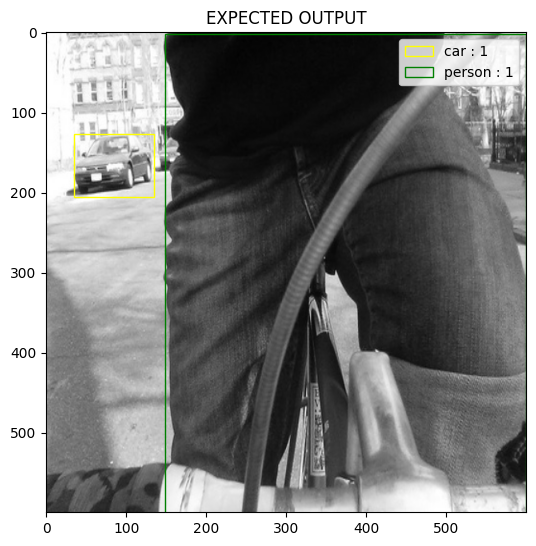

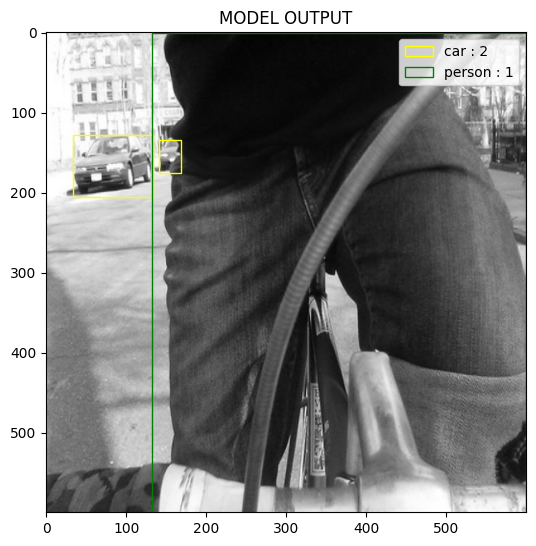

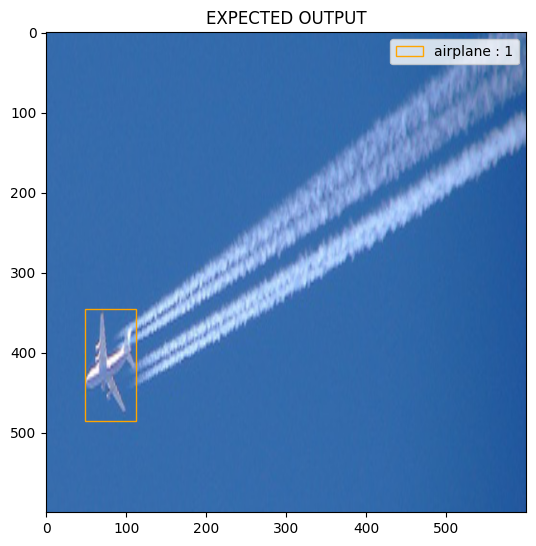

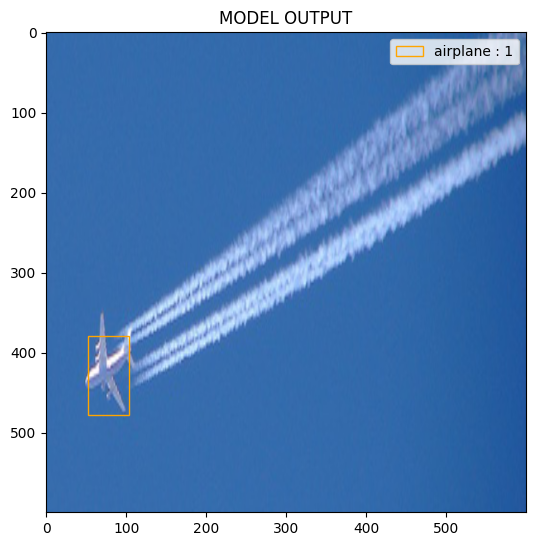

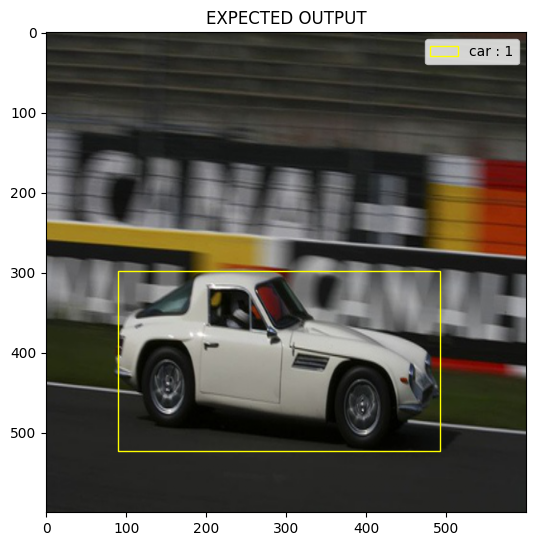

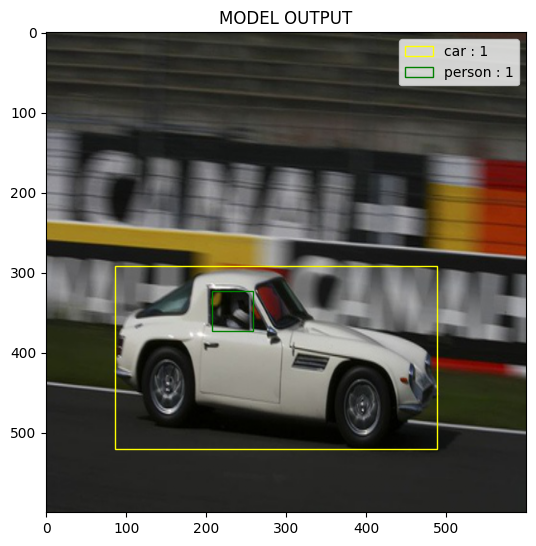

In [44]:
for i in (randint(0, len(Test_dataset.imgs), 3)):
  plot_image_test(Test_dataset[i])